# Modeling & Evvaluations for Final Filtered Mut Netphos

## Import Most Up-to-Date Dataset

In [3]:

import pandas as pd
df = pd.read_feather('../JacobSubset/filtered/mut/final-filtered-mut-netphos.feather')

df.head()

,Gene,wt,pos,mut,context,score,kinase,answer
0,ABCB1,S,35,N,KPTVSNFSM,0.470,CaM-II,.
1,ABCB1,S,35,N,KPTVSNFSM,0.469,PKA,.
2,ABCB1,S,35,N,KPTVSNFSM,0.440,GSK3,.
3,ABCB1,S,35,N,KPTVSNFSM,0.413,PKG,.
4,ABCB1,S,35,N,KPTVSNFSM,0.365,CKI,.


In [49]:
# fix answer column
df['answer'] = df['answer'].apply(lambda x: 1 if str(x).strip().upper() == 'YES' else 0).astype(int)
print(df['answer'].value_counts())
df.dtypes

answer
0    40544
1     2880
Name: count, dtype: int64


Gene        object
wt          object
pos          int64
mut         object
context     object
score      float64
kinase      object
answer       int64
dtype: object

## Build Preliminary Model

### Test-Train Split 

In [50]:

# 80-20 split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, auc, classification_report
)

X = df[['wt', 'mut', 'kinase', 'pos', 'score']]
X_encoded = pd.get_dummies(X, columns=['wt', 'mut', 'kinase'], drop_first=True)
y = df['answer']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, train_size=0.8, random_state=617, stratify=y
)

# scale our numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Model Params + Predictions

In [51]:

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# lets find the optimal value of C
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(log_model, param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print('Best C:', grid.best_params_['C'])
print('Best f1 SCore:', grid.best_score_)

Best C: 100
Best f1 SCore: 0.9806245090248332


### Model Setup

In [52]:
final_model = LogisticRegression(
    C = 100,
    max_iter=1000,
    class_weight='balanced'
)

final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
y_prob = final_model.predict_proba(X_test_scaled)[:, 1]

### Model Evaluation

In [53]:

# Get basic evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Compute Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


# Retrieve Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred))

Accuracy: 0.9973517559009787
Precision: 0.9647058823529412
Recall: 0.9965277777777778
F1 Score: 0.9803586678052946
ROC AUC: 0.999410056213261
Confusion Matrix:
[[8088   21]
 [   2  574]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8109
           1       0.96      1.00      0.98       576

    accuracy                           1.00      8685
   macro avg       0.98      1.00      0.99      8685
weighted avg       1.00      1.00      1.00      8685



+ Suspiciously high metrics
    + Perfect accuracy for class 0
    + Near perfect metrics for class 1
+ I suspect there is either:
    + Data leakage from the dummy variable
    + Too many features

### Diagnosing Any Issues

In [54]:

# lets find the exact shape of the dataset after the creation of dummy variables
print(X_encoded.shape)
print(X_encoded.sum().sort_values(ascending=False))

(43424, 51)
pos               3.947295e+07
wt_S              2.308500e+04
wt_T              1.806000e+04
score             1.409660e+04
mut_S             1.207900e+04
mut_T             1.006500e+04
kinase_unsp       3.266000e+03
mut_I             3.120000e+03
kinase_CKII       2.760000e+03
kinase_DNAPK      2.760000e+03
kinase_CaM-II     2.760000e+03
kinase_CKI        2.760000e+03
kinase_cdc2       2.760000e+03
kinase_RSK        2.760000e+03
kinase_PKG        2.760000e+03
kinase_PKB        2.760000e+03
kinase_PKA        2.760000e+03
kinase_PKC        2.760000e+03
kinase_GSK3       2.760000e+03
kinase_p38MAPK    2.760000e+03
kinase_cdk5       2.760000e+03
mut_N             2.426000e+03
wt_Y              2.016000e+03
mut_F             1.978000e+03
mut_R             1.830000e+03
mut_P             1.759000e+03
mut_C             1.745000e+03
mut_Y             1.320000e+03
mut_G             1.290000e+03
mut_L             1.260000e+03
mut_M             8.250000e+02
kinase_INSR       5.060000e

+ Over 50 features after creation of dummy variables
+ Model is definitely overfitting
    + Some dummy variables having less than 50 instances in a ss of +40,000
    + Mutation Q showing up only 4 times
+ Lets drop the rare dummy variables in an attempt to prevent overfitting

In [55]:

# filter out any dummy variables with less than 100 instances
rare_cols = [col for col in X_encoded.columns if X_encoded[col].sum() < 100]
print(f'Dropping {len(rare_cols)} rare columns: {rare_cols}')
X_encoded_filtered = X_encoded.drop(columns=rare_cols)

Dropping 15 rare columns: ['wt_C', 'wt_D', 'wt_F', 'wt_K', 'wt_L', 'wt_M', 'wt_P', 'wt_R', 'wt_V', 'mut_D', 'mut_E', 'mut_Q', 'mut_V', 'mut_W', 'mut_t']


### Recalibrating Model

In [56]:

# split data with filtered df
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_filtered, y, test_size=0.2, train_size=0.8, random_state=617, stratify=y
)

# scale our numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# lets find the optimal value of C
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(log_model, param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print('Best C:', grid.best_params_['C'])
print('Best f1 SCore:', grid.best_score_)

Best C: 100
Best f1 SCore: 0.9818829169063916


+ Nearly identical f1 score with exact same optimal value of C

In [57]:

# run final filtered model
final_filtered_model = LogisticRegression(
    C = 100,
    max_iter=1000,
    class_weight='balanced'
)

final_filtered_model.fit(X_train_scaled, y_train)
y_pred = final_filtered_model.predict(X_test_scaled)
y_prob = final_filtered_model.predict_proba(X_test_scaled)[:, 1]

# Get basic evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Compute Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


# Retrieve Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred))

Accuracy: 0.9976971790443293
Precision: 0.9664429530201343
Recall: 1.0
F1 Score: 0.9829351535836177
ROC AUC: 0.9999813735766844
Confusion Matrix:
[[8089   20]
 [   0  576]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8109
           1       0.97      1.00      0.98       576

    accuracy                           1.00      8685
   macro avg       0.98      1.00      0.99      8685
weighted avg       1.00      1.00      1.00      8685



+ No improvement from the original model
+ Let's check for feature importance by comparing coefficient per feature

### Check for Feature Importance

In [58]:
feature_importance = pd.Series(final_model.coef_[0], index=X_encoded.columns)
top_features = feature_importance.abs().sort_values(ascending=False).head(15)
print(top_features)


score            97.130050
kinase_PKB       15.857064
kinase_CaM-II    15.587533
mut_t             1.431114
wt_F              1.057025
wt_D              1.020722
wt_M              0.843848
wt_V              0.835750
kinase_cdk5       0.493685
mut_V             0.481390
mut_C             0.444629
wt_C              0.416721
mut_S             0.379789
mut_E             0.375191
mut_N             0.347997
dtype: float64


+ Glaring issue of including score in the model
+ Model is extremely reliant on score for predicting instance's class
+ Let's remove score from the set of features and retrain the model

In [59]:

# exclude score from this model
X_no_score = df[['wt', 'mut', 'kinase', 'pos']]
X_encoded_no_score = pd.get_dummies(X_no_score, drop_first=True)
print(X_encoded_no_score.shape)

(43424, 50)


### Running Model Without Score

In [60]:
# split data with filtered df
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded_no_score, y, test_size=0.2, train_size=0.8, random_state=617, stratify=y
)

# scale our numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# lets find the optimal value of C
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(log_model, param_grid, cv=5, scoring='f1')
grid.fit(X_train_scaled, y_train)

print('Best C:', grid.best_params_['C'])
print('Best f1 SCore:', grid.best_score_)

Best C: 0.1
Best f1 SCore: 0.3139056074657433


In [61]:
# run final filtered model
final_no_score_model = LogisticRegression(
    C = 0.1,
    max_iter=1000,
    class_weight='balanced'
)

final_no_score_model.fit(X_train_scaled, y_train)
y_pred = final_no_score_model.predict(X_test_scaled)
y_prob = final_no_score_model.predict_proba(X_test_scaled)[:, 1]

# Get basic evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

# Compute Confusion Matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


# Retrieve Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred))

Accuracy: 0.7516407599309154
Precision: 0.1910902696365768
Recall: 0.8489583333333334
F1 Score: 0.3119617224880383
ROC AUC: 0.8548639800084955
Confusion Matrix:
[[6039 2070]
 [  87  489]]
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8109
           1       0.19      0.85      0.31       576

    accuracy                           0.75      8685
   macro avg       0.59      0.80      0.58      8685
weighted avg       0.93      0.75      0.81      8685



### Immediate Takeaways
+ Model seems much more realistic
+ Adept at identifying class 0, terrible at identifying class 1
    + Understand considering the class imbalance
    + Good ROC-AUC despite defficiencies
+ Low precision indicates FPs
    + Class rarity plays into this
+ High recall indicates model is catching TPs
+ High F1 means the model can confidently distinguish classes from one anoher
+ Confusion matrix shows us the model likes to predict positive

### Teaching Lessons
+ Our model is actually learning about classes through mut, pos, wt, and kinase
+ No longer cheating from score which was practically telling model which is which
+ We can tune the threshold of model if we want to tune our precision vs recall
+ Let's rerun our feature importance exercise to understand what is really pushing the model

### Adjusting Model Threshold and Rerunning Feature Importance Evaluator 

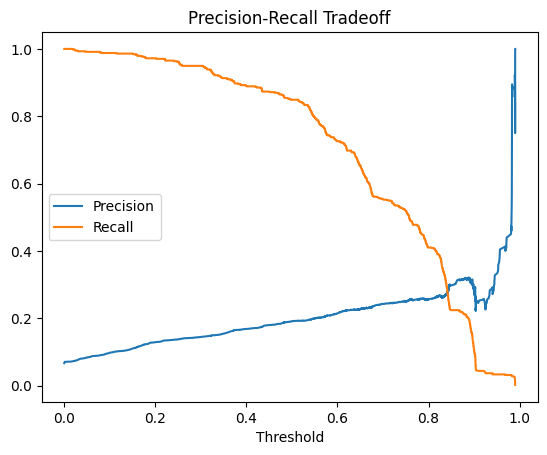

In [62]:
from sklearn.metrics import precision_recall_curve

y_probs = final_no_score_model.predict_proba(X_test_scaled)[:,1]
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
import matplotlib.pyplot as plt
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

+ From this precision-recall curve graph we can specifically choose a custom threshold
+ Depending on the applcation, the treshold can be tuned to prioritize recall or precision
    + To prioritize recall we would want a threshold around ~0.4
    + For a balance between precision and recall we would want around ~0.8 
    + For precision we would want around ~0.9
+ Lets test out the threshold tuning below:

### Prioritizing Recall

In [67]:

recall_thresh = 0.4

# apply threshold on model
y_pred_thresh = (y_probs >= recall_thresh).astype(int)

# recalculate metrics
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits=3))

[[5568 2541]
 [  63  513]]
              precision    recall  f1-score   support

           0      0.989     0.687     0.810      8109
           1      0.168     0.891     0.283       576

    accuracy                          0.700      8685
   macro avg      0.578     0.789     0.547      8685
weighted avg      0.934     0.700     0.775      8685



### Prioritizing Balance

In [65]:

recall_thresh = 0.8

# apply threshold on model
y_pred_thresh = (y_probs >= recall_thresh).astype(int)

# recalculate metrics
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits=3))

[[7422  687]
 [ 340  236]]
              precision    recall  f1-score   support

           0      0.956     0.915     0.935      8109
           1      0.256     0.410     0.315       576

    accuracy                          0.882      8685
   macro avg      0.606     0.663     0.625      8685
weighted avg      0.910     0.882     0.894      8685



### Prioritizing Precision

In [66]:

recall_thresh = 0.9

# apply threshold on model
y_pred_thresh = (y_probs >= recall_thresh).astype(int)

# recalculate metrics
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits=3))

[[7958  151]
 [ 516   60]]
              precision    recall  f1-score   support

           0      0.939     0.981     0.960      8109
           1      0.284     0.104     0.152       576

    accuracy                          0.923      8685
   macro avg      0.612     0.543     0.556      8685
weighted avg      0.896     0.923     0.906      8685



### Threshold Tuning Conclusions
+ Tuning for recall provides an extremely high recall with extremely low precision
    + Similar to the balance seen in the model above
+ Tuning for a balance between the two provides the highest F1 score
    + Fairly similar to the precision-prioritized threshold, but provides a much higher recall
+ Tuning for precision yields the highest precision, but a miniscule recall
    + Worst balance (F1 score) out of all thresholds
+ Going forward relying on the first two thresholds seems wisest

+ Now let's reconduct feature importance without the influence of 'score'

In [68]:
feature_importance = pd.Series(final_no_score_model.coef_[0], index=X_encoded_no_score.columns)
top_features = feature_importance.abs().sort_values(ascending=False).head(15)
print(top_features)

kinase_unsp       1.475877
kinase_PKC        1.233496
kinase_cdc2       0.997599
kinase_CKII       0.942332
kinase_PKA        0.887246
kinase_CaM-II     0.774298
kinase_PKG        0.691346
kinase_CKI        0.643625
kinase_INSR       0.525769
mut_P             0.511843
kinase_RSK        0.464178
kinase_GSK3       0.442618
kinase_p38MAPK    0.417175
kinase_cdk5       0.395089
kinase_SRC        0.390508
dtype: float64
